In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
# enrichment_file = "fgsea"
enrichment_file = "gprofiler"

if enrichment_file == "fgsea": # Get fgsea results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/fgsea.csv", index_col=0)
    enr.rename(columns={"pathway": "native", "col": "dim", "pval": "p_value"}, inplace=True)
    enr["dim"] = enr["dim"].str.replace("X", "").astype(int)
    enr["name"] = enr["native"]
    # Acutally, it should be padj instead of pval, but nothing is significant...

elif enrichment_file == "gprofiler": # Get gprofiler results. 
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/enrichment.csv", index_col=0)
    enr["dim"] = enr["query"].str.split(" ", expand=True)[1].astype(int)

In [90]:
enr = enr[enr["p_value"] < .05]

In [91]:
enr["minlogp"] = -np.log10(enr["p_value"])

In [92]:
enr.head()

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,method,dim,minlogp
0,GO:BP,GO:0001775,cell activation,1.375184e-23,True,"""A change in the morphology or behavior of a c...",1094,128,46,21100,0.359375,0.042048,mofa 5,['GO:0009987'],mofa,5,22.861639
1,GO:BP,GO:0045321,leukocyte activation,3.245743e-23,True,"""A change in morphology and behavior of a leuk...",953,191,52,21100,0.272251,0.054565,mofa 5,"['GO:0001775', 'GO:0002376']",mofa,5,22.488686
2,GO:BP,GO:0046649,lymphocyte activation,3.671314e-23,True,"""A change in morphology and behavior of a lymp...",794,190,48,21100,0.252632,0.060453,mofa 5,['GO:0045321'],mofa,5,22.435178
3,GO:BP,GO:0048583,regulation of response to stimulus,7.107512e-21,True,"""Any process that modulates the frequency, rat...",3895,191,97,21100,0.507853,0.024904,mofa 5,"['GO:0050789', 'GO:0050896']",mofa,5,20.148282
4,GO:BP,GO:0030098,lymphocyte differentiation,1.282312e-20,True,"""The process in which a relatively unspecializ...",391,124,29,21100,0.233871,0.074169,mofa 5,"['GO:0046649', 'GO:1903131']",mofa,5,19.892006


## Count enrichments

In [93]:
enr.groupby("method").count().reset_index()

,method,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,dim,minlogp
0,mofa,3639,3639,3639,3639,3639,3639,3639,3639,3639,3639,3639,3639,3639,3639,3639,3639
1,mowgli,14570,14570,14570,14570,14570,14570,14570,14570,14570,14570,14570,14570,14570,14570,14570,14570


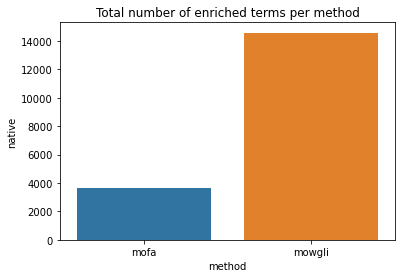

In [94]:
plt.title("Total number of enriched terms per method")
sns.barplot(data=enr.groupby("method").count().reset_index(), x="method", y="native")
plt.show()

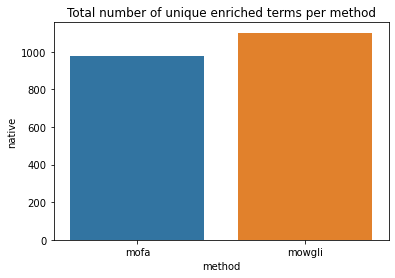

In [95]:
plt.title("Total number of unique enriched terms per method")
sns.barplot(data=enr.groupby("method")["native"].nunique().reset_index(), x="method", y="native")
plt.show()

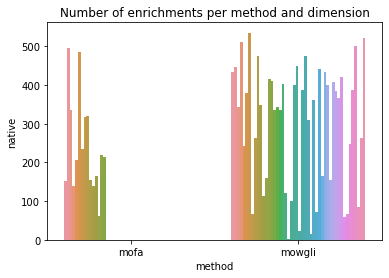

In [96]:
fig, ax = plt.subplots(1, 1)
sns.barplot(data=enr.groupby(["method", "dim"])["native"].count().reset_index(), x="method", y="native", hue="dim", ax=ax)
ax.get_legend().remove()
ax.set_title("Number of enrichments per method and dimension")
plt.show()

## Check specificity

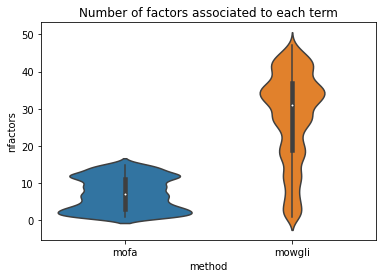

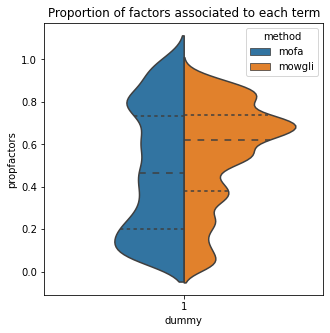

In [97]:
enr["nfactors"] = 0
nfactors = enr.groupby(["native", "method"])["native"].count()
enr.set_index(["native", "method"], inplace=True)
enr.loc[nfactors.index, "nfactors"] = nfactors
enr.reset_index(inplace=True)

plt.title("Number of factors associated to each term")
sns.violinplot(data=enr, x="method", y="nfactors")
plt.show()

enr["ndim"] = 0
enr.loc[enr["method"] == "mofa", "ndim"] = 15
enr.loc[enr["method"] == "mowgli", "ndim"] = 50
enr["propfactors"] = enr["nfactors"] / enr["ndim"]
enr["dummy"] = 1

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Proportion of factors associated to each term")
sns.violinplot(data=enr, x="dummy", hue="method", y="propfactors", split=True, ax=ax, inner="quart")
plt.show()

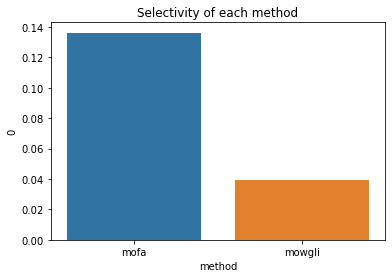

In [98]:
selectivity = (enr.groupby("method")["native"].nunique() + enr.groupby("method")["dim"].nunique()) / (2*enr.groupby("method")["native"].count())
plt.title("Selectivity of each method")
sns.barplot(data=pd.DataFrame(selectivity).reset_index(), x="method", y=0)
plt.show()

## Biology-driven check

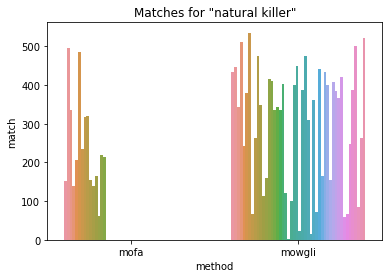

In [194]:
def barplot_matches(keywords, case=True):
    enr["match"] = enr["name"].str.contains(keywords, case=case)
    fig, ax = plt.subplots(1, 1)
    sns.barplot(
        data=enr.groupby(["method", "dim"])["match"].count().reset_index(),
        x="method",
        y="match",
        hue="dim",
        ax=ax,
    )
    ax.set_title(f'Matches for "{keywords}"')
    ax.get_legend().remove()
    plt.show()


barplot_matches("natural killer")


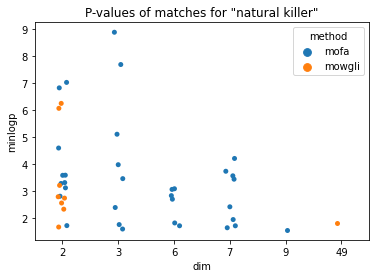

In [196]:
def stripplot_matches(keywords, case=True):
    fig, ax = plt.subplots(1, 1)
    sns.stripplot(
        data=enr[enr["name"].str.contains(keywords, case=case)],
        x="dim",
        y="minlogp",
        hue="method",
    )
    ax.set_title(f"P-values of matches for \"{keywords}\"")
    plt.show()

stripplot_matches("natural killer")